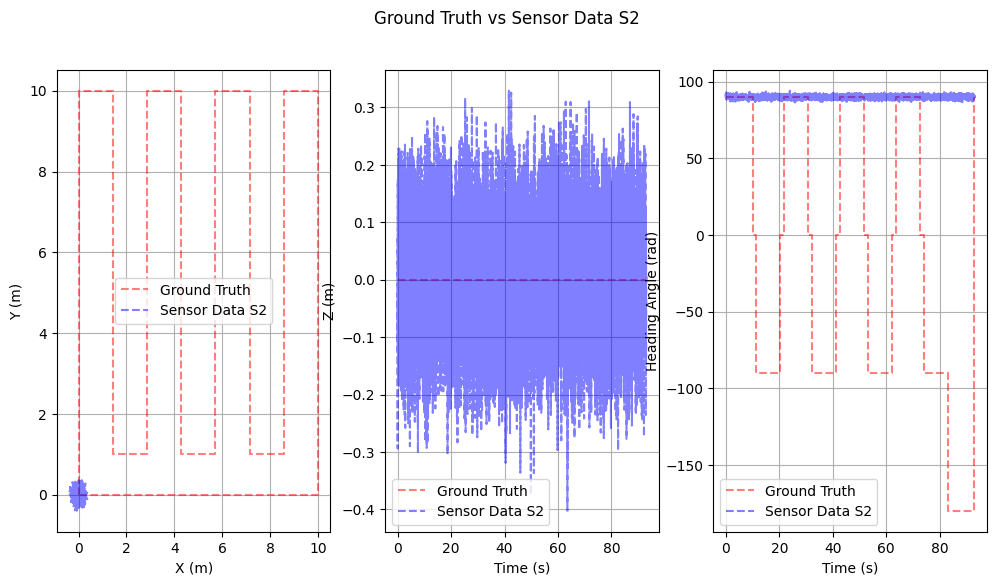

In [2]:
"""
DOCSTRING: Main file for the project
Purpose: This file will be used to run the entire project

This file will integrate all the functions, and the aspects of the problem
"""

# standard imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

# Custom imports
from dynamics import simulate_trajectory
from sensor_simulation import sensor_simulate

# Get the directory of the current script
#current_dir = os.path.dirname(os.path.abspath(__file__))
#sys.path.append(f"{current_dir}\\documentation\\bot_dynamics\\")
#from animation import animate

# We implement a Class based Simulation for the entire project

"""
DOCSTRING:
Class Name: LawnMowerField
Purpose: This class carries the parameters related to the LawnField
Class Inputs: Refer to : Generalized Lawn Field Parameters figure from DOC.md to know more about each
1. Field Dimensions: l1, l2, l3, n
2. Number of Time steps between any 2 vertices: dt

"""
class LawnMowerField():
    def __init__(self, l1: float, l2: float, l3: float, n: int, dt: int):
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.n = n
        self.dt = dt


"""
DOCSTRING:
Class Name: LawnMowerRobot
Purpose: This class carries the parameters related to the LawnMowerRobot
Class Inputs:
1. Robot velocity: v   (m/s)
2. Initial co-ordinates: t0, x0, y0, z0, theta_z0
"""
class LawnMowerRobot():
    def __init__(self, v, t0, x0, y0, z0, theta_z0):
        self.initial_cords = [t0, x0, y0, z0, theta_z0]
        self.v = v


    # Add a method for ground truth trajectory generation
    def generate_trajectory(self, field):
        # Generate the trajectory
        time, x, y, z, theta_z = simulate_trajectory(field.l1, field.l2, field.l3, self.v, field.n, field.dt, self.initial_cords)
        self.trajectory = {'time': time, 'x': x, 'y': y, 'z': z, 'theta_z': theta_z}

"""
DOCSTRING:
Class Name: Sensor
Purpose: This class carries the parameters and measurement scripts related to the Sensor
Class Inputs:
1. Sensor data rate: data_rate
2. Sensor transformation matrix: R
3. Sensor translation vector: T
4. Sensor noise model parameters: noise_params
5. Interpolation method: interp_method
"""
class Sensor():
    def __init__(self, data_rate, R, T, noise_params, interp_method, name, moving_sensor=False):
        self.data_rate = data_rate
        self.R = R
        self.T = T
        self.noise_params = noise_params
        self.interp_method = interp_method
        self.name = name
        self.moving_sensor = moving_sensor
    
    # Add a method for sensor simulation
    def simulate_sensor(self, robot):
            
        # Simulate the sensor
        self.sensor_trajectory = sensor_simulate(robot.trajectory, self.data_rate, self.R, self.T, self.noise_params, robot.v, self.interp_method, self.moving_sensor)
    
    # Add a method to convert from to GCF from Sensor Frame
    ## Takes in sensor trajectory and returns the GCF frame trajectory
    def convert_sensor_to_gcf(self, robot):

        # unpack the sensor trajectory
        time = self.sensor_trajectory['time']
        x = self.sensor_trajectory['x']
        y = self.sensor_trajectory['y']
        z = self.sensor_trajectory['z']
        theta_z = self.sensor_trajectory['theta_z']

        # form a new trajectory dictionary for GCF data
        self.converted_traj_gcf = {'time': [], 'x': [], 'y': [], 'z': [], 'theta_z': []}

        if self.moving_sensor == False:
            self.sensor_to_gcf_R = np.linalg.inv(self.R)
            self.sensor_to_gcf_T = -1*self.T

        for i in range(len(time)):

            if self.moving_sensor == True:
                # need to compute the rotation matrix and translation vector for each time step
                # compute the translation vector
                self.sensor_to_gcf_T = -1*np.array([x[i], y[i], z[i]])
                self.sensor_to_gcf_R = np.array([[np.sin(theta_z[i]), np.cos(theta_z[i]), 0],
                                                    [-np.cos(theta_z[i]), np.sin(theta_z[i]), 0],
                                                    [0, 0, 1]])

            # apply rotation matrix to the sensor frame and also apply translation
            gcf_vec = np.dot(self.sensor_to_gcf_R, np.array([x[i], y[i], z[i]])) + self.sensor_to_gcf_T

            # store to traj_gcf dictionary
            self.converted_traj_gcf['time'].append(time[i])
            self.converted_traj_gcf['x'].append(gcf_vec[0])
            self.converted_traj_gcf['y'].append(gcf_vec[1])
            self.converted_traj_gcf['z'].append(gcf_vec[2])

            # heading angle transformation
            # compute the heading angle in the sensor frame
            vx = robot.v * np.cos(theta_z[i])
            vy = robot.v * np.sin(theta_z[i])
                
            # transform velocity vector from the sensor frame to the GCF
            gcf_v = np.dot(self.sensor_to_gcf_R, np.array([vx, vy, 0]))
            theta_gcf = np.arctan2(gcf_v[1], gcf_v[0])
            self.converted_traj_gcf['theta_z'].append(theta_z[i])

        # sensor trajectory: self.sensor_trajectory

        # GCF -> Sensor Transformation was as follows:
        # [xs, ys, zs] = R * [xg, yg, zg] + T
        # vxgcf = v * cos(theta_zg)
        # vygcf = v * sin(theta_zg)
        # vs = R * [vxgcf, vygcf, 0]
        # theta_s = atan2(vs[1], vs[0])

"""
DOCSTRING:
Class Name: Animator
Purpose: This class contains parameters and methods for animating the robot motion
Class Inputs:
1. trajectory: dictionary containing the trajectory information
2. path: path to save the animated gif
"""
class Animator():
    
    def __init__(self, trajectory, path):
        self.trajectory = trajectory
        self.path = path
    
    def animate_motion(self):
        animate(self.trajectory, self.path)

"""
DOCSTRING:
Class Name: Plotter
Purpose: This class contains parameters and methods for plotting trajectories
Class Inputs:
1. trajectory: dictionary containing the trajectory information
2. sensor_trajectory: dictionary containing the sensor trajectory information
"""
class Plotter():

    def __init__(self, trajectory, sensor_trajectory, sensor):
        self.trajectory = trajectory
        self.sensor_trajectory = sensor_trajectory
        self.sensor = sensor
    
    def plot_and_compare(self):

        fig, ax = plt.subplots(1, 3, figsize=(12, 6))  # Adjusted figure size, 
        fig.suptitle("Ground Truth vs Sensor Data %s" % self.sensor.name)
        
        ax[0].set_xlabel("X (m)")
        ax[0].set_ylabel("Y (m)")
        ax[0].grid(True)
        ax[0].plot(self.trajectory['x'], self.trajectory['y'], "r--", alpha=0.5, label="Ground Truth")
        ax[0].plot(self.sensor_trajectory['x'], self.sensor_trajectory['y'], "b--", alpha=0.5, label="Sensor Data %s" % self.sensor.name)
        ax[0].legend()
        
        ax[1].set_xlabel("Time (s)")
        ax[1].set_ylabel("Z (m)")
        ax[1].grid(True)
        ax[1].plot(self.trajectory['time'], self.trajectory['z'], "r--", alpha=0.5, label="Ground Truth")
        ax[1].plot(self.sensor_trajectory['time'], self.sensor_trajectory['z'], "b--", alpha=0.5, label="Sensor Data %s" % self.sensor.name)
        ax[1].legend()

        ax[2].set_xlabel("Time (s)")
        ax[2].set_ylabel("Heading Angle (rad)")
        ax[2].grid(True)
        ax[2].plot(self.trajectory['time'], self.trajectory['theta_z'], "r--", alpha=0.5, label="Ground Truth")
        ax[2].plot(self.sensor_trajectory['time'], self.sensor_trajectory['theta_z'], "b--", alpha=0.5, label="Sensor Data %s" % self.sensor.name)
        ax[2].legend()

        plt.show()


# Main function
# Initialize the LawnMowerField
field = LawnMowerField(10, 1.428, 1, 2, 50)

# Initialize the LawnMowerRobot
bot = LawnMowerRobot(1, 0.0, 0.0, 0.0, 0.0, 90.0)

# Generate ground truth trajectory -> stored in bot.trajectory
bot.generate_trajectory(field)

# Initialize the Sensors
S1 = Sensor(2.5, np.eye(3), np.array([-10, -10, -100]), np.array([0.05, 0.05, 0.05, 0.5]), 'linear', "S1")

# Since the frame S2 moves along with the robot, its rotation matrix and translation vector with respect to GCF keep changing
# 'simulate' is a special parameter which when given to matrices R and T, will simulate the sensor frame moving along with the robot in real time
S2 = Sensor(100, np.eye(3), np.zeros(3), np.array([0.1, 0.1, 0.1, 1.0]), 'linear', "S2", True)

# Simulate the sensor -> stored in S1.sensor_trajectory
S1.simulate_sensor(bot)

# Simulate the sensor -> stored in S2.sensor_trajectory
S2.simulate_sensor(bot)

# Convert the sensor trajectory back to GCF -> in order to compare with ground truth
# Stored in S1.converted_traj_gcf
S1.convert_sensor_to_gcf(bot)

# Convert the sensor trajectory back to GCF -> in order to compare with ground truth
# Stored in S2.converted_traj_gcf
S2.convert_sensor_to_gcf(bot)

# Plot and Compare
#plotter = Plotter(bot.trajectory, S1.sensor_trajectory, S1)
#plotter.plot_and_compare()

# Plot and Compare
plotter = Plotter(bot.trajectory, S2.sensor_trajectory, S2)
plotter.plot_and_compare()

# Animate the robot motion for ground truth and sensor data
#gt_anime_path = "D:\\Career\\Interviews\\GncCoding_Soham\\documentation\\bot_dynamics\\lawn_mover_animation_gcf.gif"
#sensor_anime_path = "D:\\Career\\Interviews\\GncCoding_Soham\\documentation\\bot_dynamics\\lawn_mover_animation_sensor_frame.gif"

# Animate the ground truth : Initialize an Animator object
#gt_animator = Animator(bot.trajectory, gt_anime_path)
#gt_animator.animate_motion()

In [5]:
np.cos(np.radians(90))

np.float64(6.123233995736766e-17)

In [6]:
v = 3
vx = v * np.cos(np.radians(60))
vy = v * np.sin(np.radians(60))
vz = 0 # we know this, since the angle measured is in the xy plane only

# transform velocity vector from the GCF to the sensor frame
sensor_v = np.dot(np.eye(3), np.array([vx, vy, vz]))
theta_sensor = np.degrees(np.arctan2(sensor_v[1], sensor_v[0]))
print(theta_sensor)

59.99999999999999
